# Milk Spoilage: Stochastic Modeling Project
## Author: Indervir Dhillon
## Date: April 15 2025

### Project Overview: This notebook implements a stochastic birth-death process model to analyze the spoilage dynamics of milk due to Bacillus cereus contamination.
 We'll investigate:
 - Base spoilage dynamics at constant temperature
 - Effect of UV treatment on shelf life
 - Impact of temperature variation on spoilage time

# Plot of Mean Spoilage Time and CDF and Sell-By Date


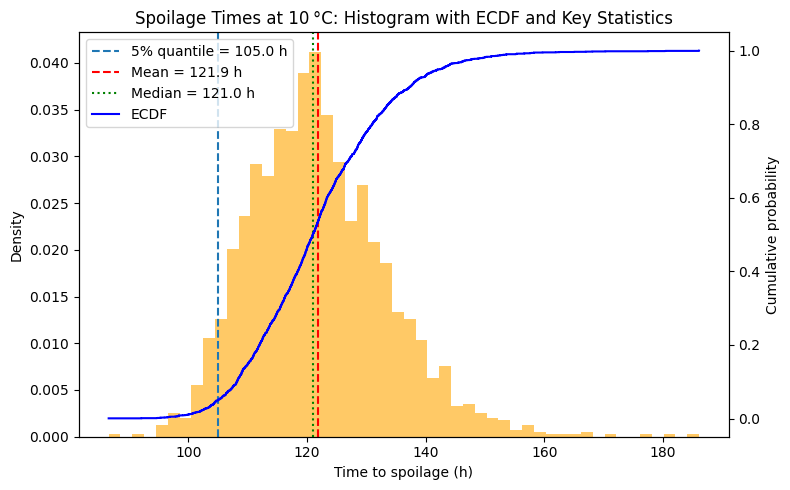

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS & FUNCTIONS
# -----------------------------
K = 1000
n0 = 10
T_const = 10
T_MAX = 200   # hours
NSIM = 2000
a_RATKOWSKY = 0.001427
d0 = 0.010
d_temp_coeff = 0.05

rng = np.random.default_rng(42)

def b_temp(T):
    return a_RATKOWSKY * max(T - 4.0, 0.0)**2

def d_temp(T):
    return d0 * (1 + d_temp_coeff * max(T - 4.0, 0.0))

def gillespie_const(T, Tmax):
    t, N = 0.0, n0
    while N < K and t < Tmax:
        b, d = b_temp(T), d_temp(T)
        rate = (b + d) * N
        if rate <= 0:
            return np.inf
        dt = rng.exponential(1 / rate)
        t += dt
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

# -----------------------------
# SIMULATION
# -----------------------------
times = np.array([gillespie_const(T_const, T_MAX) for _ in range(NSIM)])
finite = times[np.isfinite(times)]

# -----------------------------
# SUMMARY STATISTICS
# -----------------------------
mean_h   = finite.mean()
median_h = np.median(finite)
sell_h   = np.quantile(finite, 0.05)

# -----------------------------
# ECDF DATA
# -----------------------------
x_ecdf = np.sort(finite)
y_ecdf = np.arange(1, len(x_ecdf) + 1) / len(x_ecdf)

# -----------------------------
# COMBINED PLOT
# -----------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Histogram
ax1.hist(finite, bins=50, density=True, alpha=0.6, color='orange')
ax1.axvline(sell_h, linestyle='--', label=f"5% quantile = {sell_h:.1f} h")
ax1.axvline(mean_h, linestyle='--', color='red',    label=f"Mean = {mean_h:.1f} h")
ax1.axvline(median_h, linestyle=':', color='green',  label=f"Median = {median_h:.1f} h")
ax1.set_xlabel("Time to spoilage (h)")
ax1.set_ylabel("Density")

# ECDF on second axis
ax2 = ax1.twinx()
ax2.step(x_ecdf, y_ecdf, where='post', color='blue', label='ECDF')
ax2.set_ylabel("Cumulative probability")

# Merge legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.title("Spoilage Times at 10 °C: Histogram with ECDF and Key Statistics")
plt.tight_layout()
plt.show()



## Additional Check on Statistics

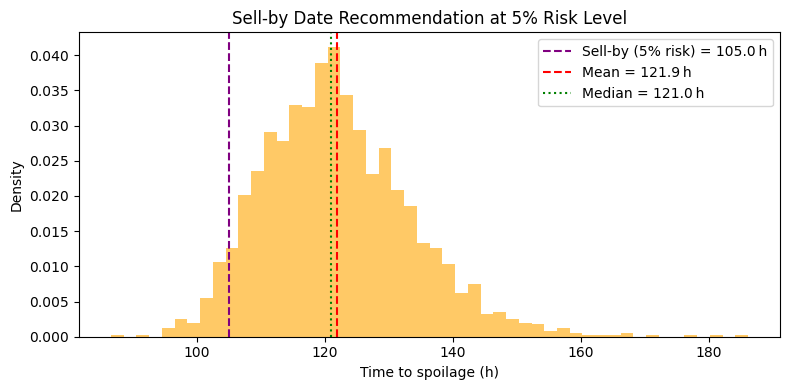

In [16]:
# Compute summary statistics
mean_h   = finite_times.mean()
sell_h   = np.quantile(finite_times, 0.05)  # 5% quantile for sell-by
median_h = np.median(finite_times)

# -----------------------------
# 2. PLOT SELL-BY RECOMMENDATION
# -----------------------------
plt.figure(figsize=(8, 4))
plt.hist(finite_times, bins=50, density=True, alpha=0.6, color='orange')
plt.axvline(sell_h, linestyle='--', color='purple', label=f"Sell‑by (5% risk) = {sell_h:.1f} h")
plt.axvline(mean_h, linestyle='--', color='red',    label=f"Mean = {mean_h:.1f} h")
plt.axvline(median_h, linestyle=':', color='green',  label=f"Median = {median_h:.1f} h")
plt.xlabel("Time to spoilage (h)")
plt.ylabel("Density")
plt.title("Sell‑by Date Recommendation at 5% Risk Level")
plt.legend()
plt.tight_layout()
plt.show()


# Computing Optimal UV Time
Note Grid search takes a while to run 

In [22]:
import numpy as np

# -----------------------------
# PARAMETERS & FUNCTIONS
# -----------------------------
K = 1000
n0 = 10
T_const = 10
T_MAX = 200   # hours
NSIM = 2000
a_RATKOWSKY = 0.001427
d0 = 0.010
d_temp_coeff = 0.05
UV_KILL = 0.05  # survivors fraction after 95% kill

rng = np.random.default_rng(42)

def b_temp(T):
    return a_RATKOWSKY * max(T - 4.0, 0.0)**2

def d_temp(T):
    return d0 * (1 + d_temp_coeff * max(T - 4.0, 0.0))

def gillespie_const(T, Tmax, rng):
    t, N = 0.0, n0
    while N < K and t < Tmax:
        b, d = b_temp(T), d_temp(T)
        rate = (b + d) * N
        if rate <= 0:
            return np.inf
        dt = rng.exponential(1 / rate)
        t += dt
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

def gillespie_with_uv(T_profile, Tmax, t_uv, rng):
    t, N = 0.0, n0
    uv_applied = False
    while N < K and t < Tmax:
        b = b_temp(T_profile(t))
        d = d_temp(T_profile(t))
        rate = (b + d) * N
        if rate <= 0:
            return np.inf
        dt = rng.exponential(1 / rate)
        t += dt
        if not uv_applied and t >= t_uv:
            N = int(np.floor(UV_KILL * N))
            uv_applied = True
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

# constant temperature profile
const_profile = lambda t: T_const

# -----------------------------
# 1) Baseline (no UV)
# -----------------------------
times_no_uv = np.array([gillespie_const(T_const, T_MAX, rng) for _ in range(NSIM)])
finite_no_uv = times_no_uv[np.isfinite(times_no_uv)]
baseline_quantile = np.quantile(finite_no_uv, 0.05)

# -----------------------------
# 2) Grid search for optimal t_uv
# -----------------------------
candidate_times = np.arange(0, T_MAX + 1, 5.0)  # every 5 hours
extensions = []

for t_uv in candidate_times:
    # reset RNG for comparability
    rng = np.random.default_rng(42)
    times_uv = np.array([gillespie_with_uv(const_profile, T_MAX, t_uv, rng)
                         for _ in range(NSIM)])
    finite_uv = times_uv[np.isfinite(times_uv)]
    if finite_uv.size > 0:
        q_uv = np.quantile(finite_uv, 0.05)
        extensions.append(q_uv - baseline_quantile)
    else:
        extensions.append(-np.inf)

# find optimal
extensions = np.array(extensions)
best_idx = np.argmax(extensions)
optimal_t_uv = candidate_times[best_idx]
optimal_extension = extensions[best_idx]

print(f"Optimal UV shock time ≈ {optimal_t_uv:.1f} h")
print(f"Shelf‑life extension at that time ≈ {optimal_extension:.1f} h")


Optimal UV shock time ≈ 95.0 h
Shelf‑life extension at that time ≈ 73.2 h


# Computing New 5% Quantile

In [21]:

# Gillespie at constant T
def gillespie_const(T, Tmax, rng):
    t, N = 0.0, n0
    while N < K and t < Tmax:
        b, d = b_temp(T), d_temp(T)
        rate = (b + d) * N
        if rate <= 0: break
        dt = rng.exponential(1 / rate)
        t += dt
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

# Gillespie with one UV shock at t_uv
def gillespie_with_uv(T_profile, Tmax, t_uv, rng):
    t, N = 0.0, n0
    uv_applied = False
    while N < K and t < Tmax:
        b = b_temp(T_profile(t))
        d = d_temp(T_profile(t))
        rate = (b + d) * N
        if rate <= 0: break
        dt = rng.exponential(1 / rate)
        t += dt
        if not uv_applied and t >= t_uv:
            N = int(np.floor(UV_KILL * N))
            uv_applied = True
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

# constant temperature profile
const_profile = lambda t: T_const

# -----------------------------
# 1) Sell-by without UV
# -----------------------------
# reset RNG for reproducibility
rng = np.random.default_rng(42)
times_no_uv = np.array([gillespie_const(T_const, T_MAX, rng) for _ in range(NSIM)])
finite_no_uv = times_no_uv[np.isfinite(times_no_uv)]
sell_no_uv = np.quantile(finite_no_uv, 0.05)

# -----------------------------
# 2) Sell-by with UV at computed T
# -----------------------------
# reset RNG to get the same base seed
rng = np.random.default_rng(42)
t_uv = 95.0
times_uv = np.array([gillespie_with_uv(const_profile, T_MAX, t_uv, rng) for _ in range(NSIM)])
finite_uv = times_uv[np.isfinite(times_uv)]
sell_uv = np.quantile(finite_uv, 0.05)

# -----------------------------
# 3) Report
# -----------------------------
extension_sell_h = sell_uv - sell_no_uv
extension_sell_d = extension_sell_h / 24

print(f"5% quantile without UV: {sell_no_uv:.1f} h ({sell_no_uv/24:.2f} days)")
print(f"5% quantile with UV @ {t_uv} h: {sell_uv:.1f} h ({sell_uv/24:.2f} days)")
print(f"Extension in sell-by (5% quantile): {extension_sell_h:.1f} h ({extension_sell_d:.2f} days)")


5% quantile without UV: 105.0 h (4.38 days)
5% quantile with UV @ 95.0 h: 178.2 h (7.43 days)
Extension in sell-by (5% quantile): 73.2 h (3.05 days)


# Plot for UV Treatment 

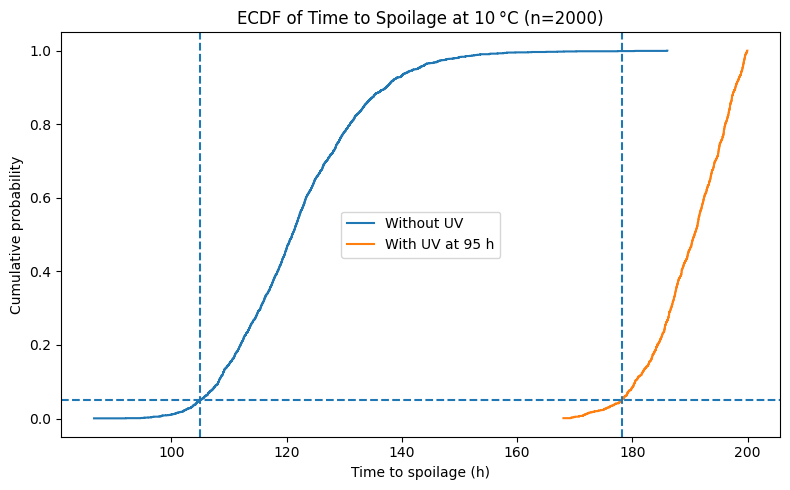

5% quantile without UV: 105.0 h (4.38 days)
5% quantile with UV @ 95.0 h: 178.2 h (7.43 days)
Extension in sell-by (5% quantile): 73.2 h (3.05 days)


In [25]:
# -----------------------------
# ECDF function
# -----------------------------
def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, y

sorted_no_uv, y_no_uv = ecdf(finite_no_uv)
sorted_uv, y_uv = ecdf(finite_uv)

# -----------------------------
# PLOT
# -----------------------------
plt.figure(figsize=(8, 5))

plt.step(sorted_no_uv, y_no_uv, where='post', label='Without UV')
plt.step(sorted_uv, y_uv, where='post', label=f'With UV at {t_uv:.0f} h')

# 5% quantile markers
plt.axhline(0.05, linestyle='--')
plt.axvline(sell_no_uv, linestyle='--')
plt.axvline(sell_uv, linestyle='--')

plt.xlabel('Time to spoilage (h)')
plt.ylabel('Cumulative probability')
plt.title('ECDF of Time to Spoilage at 10 °C (n=2000)')
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# PRINT SUMMARY
# -----------------------------
extension_sell_h = sell_uv - sell_no_uv
extension_sell_d = extension_sell_h / 24

print(f"5% quantile without UV: {sell_no_uv:.1f} h ({sell_no_uv/24:.2f} days)")
print(f"5% quantile with UV @ {t_uv} h: {sell_uv:.1f} h ({sell_uv/24:.2f} days)")
print(f"Extension in sell-by (5% quantile): {extension_sell_h:.1f} h ({extension_sell_d:.2f} days)")


# Plot for Temperature Dependent Rates

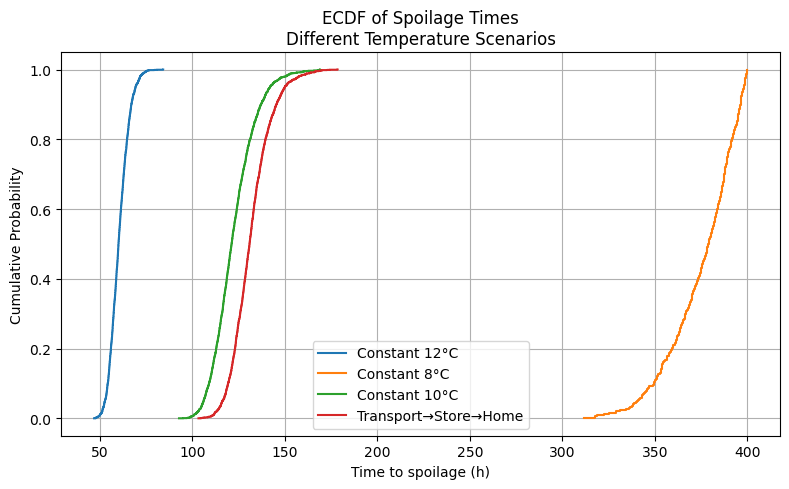

In [26]:
# piecewise temperature profile: transport → store → home
def make_piecewise_profile(t1, t2, T_trans, T_store, T_home):
    def T_profile(t):
        if t < t1:
            return T_trans
        elif t < t2:
            return T_store
        else:
            return T_home
    return T_profile

# Gillespie simulation with time‐varying temperature
def gillespie_varT(T_profile, Tmax):
    t = 0.0
    N = n0
    while N < K and t < Tmax:
        Tnow = T_profile(t)
        b = b_temp(Tnow)
        d = d_temp(Tnow)
        total_rate = (b + d) * N
        if total_rate <= 0:
            return np.inf
        dt = rng.exponential(1 / total_rate)
        t += dt
        if rng.random() < b / (b + d):
            N += 1
        else:
            N = max(N - 1, 0)
    return t if N >= K else np.inf

# Define profiles to compare
t1, t2 = 24.0, 72.0
T_trans, T_store, T_home = 12.0, 8.0, 10.0
piecewise = make_piecewise_profile(t1, t2, T_trans, T_store, T_home)

profiles = {
    'Constant 12°C': lambda t: 12.0,
    'Constant 8°C':  lambda t: 8.0,
    'Constant 10°C': lambda t: 10.0,
    'Transport→Store→Home': piecewise
}

# Simulate and plot ECDFs
plt.figure(figsize=(8, 5))
for label, profile in profiles.items():
    times = np.array([gillespie_varT(profile, T_max) for _ in range(NSIM)])
    finite = times[np.isfinite(times)]
    if finite.size == 0:
        continue
    sorted_times = np.sort(finite)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.step(sorted_times, y, where='post', label=label)

plt.xlabel('Time to spoilage (h)')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Spoilage Times\nDifferent Temperature Scenarios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

